In [ ]:
import itertools
import sys
import os
sys.path.append("../") # go to parent dir

import jax
import jax.random as jr
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import numpy as np
from scipy.stats import rankdata
import scipy.stats as ss
import seaborn as sns
from sklearn.model_selection import KFold

jnp.set_printoptions(precision=2)

# from data.create_sim_data import *
import data.template_causl_simulations as causl_py
from data.run_all_simulations import plot_simulation_results
import data.hyperparam_and_bootstrapping as hb
from frugal_flows.causal_flows import independent_continuous_marginal_flow, get_independent_quantiles, train_frugal_flow, train_copula_flow
from frugal_flows.bijections import UnivariateNormalCDF

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage
import wandb

# Activate automatic conversion of rpy2 objects to pandas objects
pandas2ri.activate()

# Import the R library causl
try:
    causl = importr('causl')
except Exception as e:
    package_names = ('causl')
    utils.install_packages(StrVector(package_names))


jax.config.update("jax_enable_x64", True)

sweep_configuration = {
    "name": "e401-random",
    "method": "random",
    "metric": {"goal": "minimize", "name": "val_loss"},
    "parameters": {
        "learning_rate": {"min": 1e-5, "max": 1e-2},
        "RQS_knots": {"min": 1, "max": 20},
        "flow_layers": {"min": 1, "max": 20},
        "nn_width": {"min": 10, "max": 50},
        "nn_depth": {"min": 1, "max": 10},
        # "max_patience": {"min": 1, "max": 20},
        # "max_epochs": {"min": 1, "max": 20},
        "seed": {"min": 0, "max": 100},
    },
}
sweep_id = wandb.sweep(sweep=sweep_configuration, project="frugal-flows")

e401k = pd.read_csv('../data/filtered_401k_data.csv')

outcome_col = 'net_tfa'
treatment_col = 'e401'
standardised_outcome_col = f'{outcome_col}_standardised'
Y_control = e401k.loc[e401k[treatment_col]==0, outcome_col]
Y_control_mean = Y_control.mean()
Y_control_std = Y_control.std()
e401k[standardised_outcome_col] = (e401k[outcome_col] - Y_control_mean) / Y_control_std
e401k_filtered = e401k.loc[(e401k[standardised_outcome_col] > -2) & (e401k[standardised_outcome_col] < +3)]

X = jnp.array(e401k_filtered[treatment_col].values)[:, None]
Y = jnp.array(e401k_filtered[standardised_outcome_col].values)[:, None]

Z_disc = jnp.array(e401k_filtered[[
    col for col in e401k_filtered.columns if col not in [outcome_col,standardised_outcome_col, treatment_col]
]].values)

def run_cmd():
    run = wandb.init()
    hyperparams_dict = {
        "learning_rate": wandb.config.learning_rate,
        "RQS_knots": wandb.config.RQS_knots,
        "flow_layers": wandb.config.flow_layers,
        "nn_width": wandb.config.nn_width,
        "nn_depth": wandb.config.nn_depth,
        "max_patience": 200,#wandb.config.max_patience,
        "max_epochs": 20000,#.config.max_epochs,
        "batch_size": 500
    }
    causl_py.frugal_fitting(X, Y, Z_disc=Z_disc, seed=wandb.config.seed, frugal_flow_hyperparams=hyperparams_dict)

# Start sweep job.
wandb.agent(sweep_id, function=run_cmd, count=10)

# hyperparams_dict = {
#     'learning_rate': 1e-3,
#     'RQS_knots': 8,
#     'flow_layers': 10,
#     'nn_width': 50,
#     'nn_depth': 10,    
#     'max_patience': 100,
#     'max_epochs': 20000
# }

Create sweep with ID: qx9a6zvu
Sweep URL: https://wandb.ai/dmman180/frugal-flows/sweeps/qx9a6zvu


wandb: Agent Starting Run: 9tl9aais with config:
wandb: 	RQS_knots: 11
wandb: 	flow_layers: 6
wandb: 	learning_rate: 0.005325427610999746
wandb: 	nn_depth: 8
wandb: 	nn_width: 48
wandb: 	seed: 30
wandb: Currently logged in as: man180 (dmman180). Use `wandb login --relogin` to force relogin


Run 9tl9aais errored:
Traceback (most recent call last):
  File "/Users/danielmanela/micromamba/envs/deep-frugal/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 307, in _run_job
    self._function()
  File "/var/folders/56/lsfdgvh92jx680bppqq2qrxh0000gn/T/ipykernel_99877/2255679704.py", line 94, in run_cmd
    causl_py.frugal_fitting(X, Y, Z_disc=Z_disc, seed=wandb.config.seed, frugal_flow_hyperparams=hyperparams_dict)
  File "/Users/danielmanela/Library/CloudStorage/GoogleDrive-danielmanela@gmail.com/My Drive/work/deep-copula-frugal/validation/../data/template_causl_simulations.py", line 141, in frugal_fitting
    frugal_flow, losses = train_frugal_flow(
                          ^^^^^^^^^^^^^^^^^^
  File "/Users/danielmanela/Library/CloudStorage/GoogleDrive-danielmanela@gmail.com/My Drive/work/deep-copula-frugal/validation/../frugal_flows/causal_flows.py", line 566, in train_frugal_flow
    raise ValueError(f"Invalid choice. Please choose from: {valid_causal_models}")
Val

In [ ]:
hyperparams_dict = {
    'learning_rate': 0.006335,
    'RQS_knots': 4,
    'flow_layers': 9,
    'nn_depth': 10,    
    'nn_width': 50,
    'max_patience': 200,
    'max_epochs': 20000
}
SEED = 1

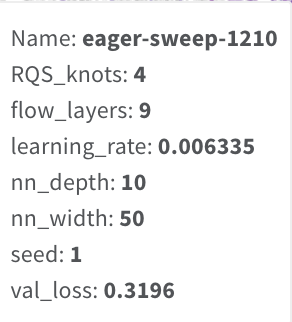

## Load Data

In [ ]:
e401k = pd.read_csv('../data/filtered_401k_data.csv')
e401k.head()

In [ ]:
e401k = pd.read_csv('../data/filtered_401k_data.csv')

outcome_col = 'net_tfa'
treatment_col = 'e401'
standardised_outcome_col = f'{outcome_col}_standardised'
Y_control = e401k.loc[e401k[treatment_col]==0, outcome_col]
Y_control_mean = Y_control.mean()
Y_control_std = Y_control.std()
e401k[standardised_outcome_col] = (e401k[outcome_col] - Y_control_mean) / Y_control_std
e401k_filtered = e401k.loc[(e401k[standardised_outcome_col] > -2) & (e401k[standardised_outcome_col] < +3)]

X = jnp.array(e401k_filtered[treatment_col].values)[:, None]
Y = jnp.array(e401k_filtered[standardised_outcome_col].values)[:, None]

Z_disc = jnp.array(e401k_filtered[[
    col for col in e401k_filtered.columns if col not in [outcome_col,standardised_outcome_col, treatment_col]
]].values)

plt.hist(e401k_filtered.loc[e401k_filtered[treatment_col]==0, standardised_outcome_col], label='Control', bins=30, alpha=0.3);
plt.hist(e401k_filtered.loc[e401k_filtered[treatment_col]==1, standardised_outcome_col], label='Treatment', bins=30, alpha=0.3);
plt.legend()

In [ ]:
wandb.init()
flow_object, min_val_loss = causl_py.frugal_fitting(X, Y, Z_disc=Z_disc, seed=SEED+1, frugal_flow_hyperparams=hyperparams_dict)

In [ ]:
min_val_loss

In [ ]:
training_losses = np.array(flow_object['losses']['train'])
val_losses = np.array(flow_object['losses']['val'])
it = list(range(len(flow_object['losses']['train'])))
plt.plot(training_losses, label='Training')
plt.plot(val_losses, label='Test')
plt.legend()

In [ ]:
uz_samples = causl_py.generate_uz_samples(seed=0, Z_disc=Z_disc)['uz_samples']
data_raw = jnp.hstack([uz_samples, Y])

data = (data_raw, X)
data = tuple(jnp.asarray(a) for a in data)

key_pre_data_splitting = jax.random.key_data(jnp.array([2924961310, 361661401]).astype('uint32'))
key, subkey = jr.split(key_pre_data_splitting)

from flowjax.train.train_utils import train_val_split
train_data, val_data = train_val_split(subkey, data, val_prop=0.1)

In [ ]:
sns.pairplot(
    pd.DataFrame(np.array(train_data[:10][0][:, :-1])), 
    diag_kind='kde', plot_kws={'alpha':0.2}, height=1
)

In [ ]:
flow_samples = flow_object['frugal_flow'].sample(
    key=jr.PRNGKey(0), 
    sample_shape=(1000,), 
    condition=jnp.zeros(shape=(1))
)
sns.pairplot(pd.DataFrame(np.array(flow_samples[:, 1:])), diag_kind='kde', plot_kws={'alpha':0.2}, height=1)

OLD FLOW SAMPLES

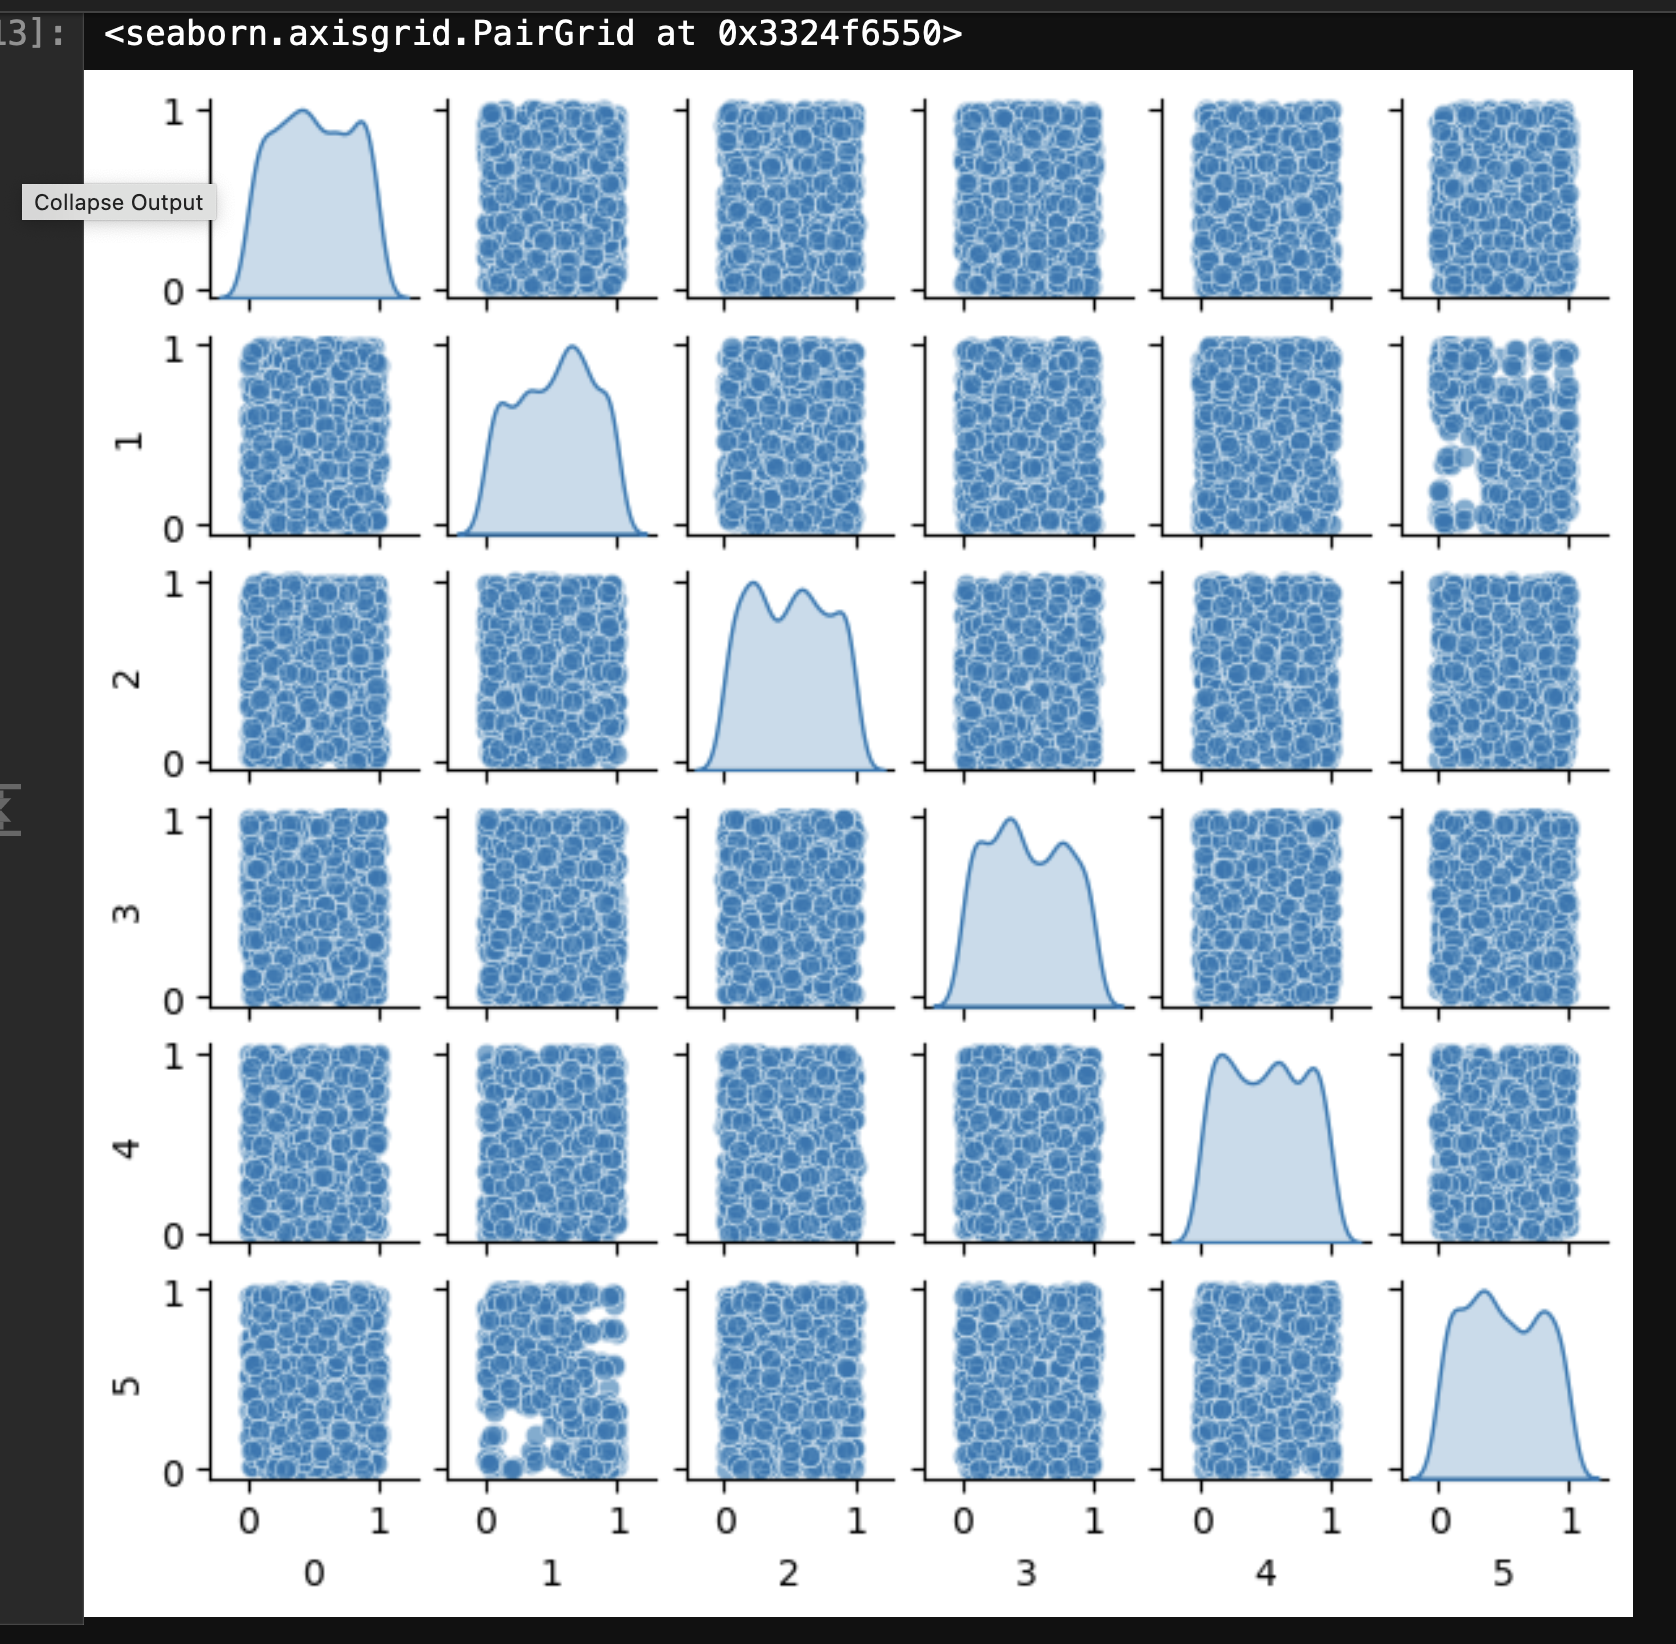

In [ ]:
training_losses = np.array(fitted_flow['losses']['train'])
val_losses = np.array(fitted_flow['losses']['val'])
it = list(range(len(fitted_flow['losses']['train'])))
plt.plot(training_losses, label='Training')
plt.plot(val_losses, label='Test')
plt.legend()

In [ ]:
fitted_flow['causal_margin'].ate

In [ ]:
fitted_flow['causal_margin'].const

In [ ]:
fitted_flow['causal_margin'].scale

In [ ]:
flow_samples = fitted_flow['frugal_flow'].sample(
    key=jr.PRNGKey(0), 
    sample_shape=(1000,), 
    condition=jnp.zeros(shape=(1))
)
sns.pairplot(pd.DataFrame(np.array(flow_samples[:, 1:])), diag_kind='kde', plot_kws={'alpha':0.6}, height=1)

In [ ]:
hyperparams_dict_v2 = {
    'learning_rate': 1e-3,
    'RQS_knots': 8,
    'flow_layers': 4,
    'nn_width': 50,
    'nn_depth': 4,    
    'max_patience': 50,
    'max_epochs': 20000
}

fitted_flow_v2 = causl_py.frugal_fitting(
    X=None, 
    Y=jr.normal(key=jr.PRNGKey(98), shape=(Y.shape[0], 1)), 
    Z_disc=Z_disc, 
    seed=0, 
    frugal_flow_hyperparams=hyperparams_dict_v2
)
flow_v2 = fitted_flow_v2['frugal_flow']

In [ ]:
flow_samples = flow_v2.sample(key=jr.PRNGKey(0), sample_shape=(1000,))#, condition=jnp.zeros(shape=(1,)))

In [ ]:
jnp.corrcoef(jax.scipy.special.ndtri(res['u_z_discr']).T)

In [ ]:
jnp.corrcoef(jax.scipy.special.ndtri(flow_samples[:, 1:]).T)

In [ ]:
sns.pairplot(pd.DataFrame(np.array(flow_samples[:, 1:])), diag_kind='kde', plot_kws={'alpha':0.6}, height=1)

In [ ]:
sns.pairplot(pd.DataFrame(np.array(res['u_z_discr'])), diag_kind='kde', plot_kws={'alpha':0.6}, height=1)

In [ ]:
sns.pairplot(pd.DataFrame(np.array(res['u_z_discr'])), diag_kind='kde', plot_kws={'alpha':0.6}, height=1)

In [ ]:
lalonde.value_counts(['black', 'hispanic'])

In [ ]:
sns.pairplot(pd.DataFrame(np.array(Z_disc)), diag_kind='kde', plot_kws={'alpha':0.6}, height=1)

In [ ]:
sns.pairplot(pd.DataFrame(np.array(res['u_z_discr'])), diag_kind='kde', plot_kws={'alpha':0.6}, height=1)

In [ ]:
def rankdata(z_disc):
    z_disc_ordered = []
    z_rank_mapping = {}
    for d in range(z_disc.shape[1]):
        z_disc_d = z_disc[:, d]
        unique_z_disc_d = jnp.unique(z_disc_d)
        rank_mapping = {k: v for k, v in zip(np.array(unique_z_disc_d), np.arange(len(unique_z_disc_d)))}
        z_disc_new = jnp.array([rank_mapping[i] for i in np.array(z_disc_d)])
        z_disc_ordered.append(z_disc_new)
        z_rank_mapping[d] = rank_mapping
    return jnp.vstack(z_disc_ordered), z_rank_mapping

In [ ]:
Z_disc.shape

In [ ]:
rankdata(Z_disc)[0].shape

In [ ]:
pmf_vals

In [ ]:
pmf_keys

In [ ]:
z_discr_empirical_pmf.cumsum()

In [ ]:
z_discr_empirical_pmf

In [ ]:
def uniform_shift(standard_uniform, upper_index):
    # Function to handle the case where upper_index != 0
    def not_zero():
        lower = z_discr_empirical_cdf_long[upper_index - 1]
        upper = z_discr_empirical_cdf_long[upper_index]
        return standard_uniform * (upper - lower) + lower

    # Function to handle the case where upper_index == 0
    def zero():
        upper = z_discr_empirical_cdf_long[upper_index]
        return standard_uniform * upper

In [ ]:
uniform_shift(0.5, 3)

In [ ]:
plt.hist(Z_disc[:,0])

In [ ]:
plt.hist(causl_py.calculate_ecdf(Z_disc[:,0][:, None]).T)

In [ ]:
temp = Z_disc[:,

In [ ]:
z_disc_new

In [ ]:
sns.pairplot(pd.DataFrame(np.array(Z_disc)), diag_kind='kde', plot_kws={'alpha':0.6})

In [ ]:
quantiles['u_z_discr'][:,0]

In [ ]:
sns.pairplot(pd.DataFrame(np.array(quantiles['u_z_discr'])), diag_kind='kde', plot_kws={'alpha':0.6})

In [ ]:
Z_disc[:,0][:,None]

In [ ]:
actual_quantiles = get_independent_quantiles(
    key=jr.PRNGKey(0), z_cont=Z_disc[:,0][:,None], z_discr=Z_disc[:,1:], **hyperparams_dict
)

In [ ]:
actual_quantiles['u_z_cont']

In [ ]:
sns.pairplot(pd.DataFrame(np.array(actual_quantiles)), diag_kind='kde', plot_kws={'alpha':0.6})

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(pd.DataFrame(np.array(fitted_flow['uz_disc']).T), diag_kind='kde', plot_kws={'alpha':0.6})
plt.show()

In [ ]:
data = causl_py.generate_gaussian_samples(N=1000, causal_params=[1,1], seed=0)
Z_cont = data.get('Z_cont')
X = data.get('X')
Y = data.get('Y')

In [ ]:
# Define the hyperparameter ranges
param_grid = {
    'RQS_knots': [4, 6, 8],
    'flow_layers': [4, 6, 8],
    'nn_width': [20, 40, 60],
    'nn_depth': [4, 6, 8],
    'learning_rate': [3e-3, 5e-3],
    'batch_size': [1000],
    'max_patience': [50],
    'max_epochs': [10000]
}

param_combinations = hb.generate_param_combinations(param_grid)

In [ ]:
hyperparam_fits = hb.gaussian_outcome_hyperparameter_search(
    X, Y, Z_disc=None, Z_cont=Z_cont, param_combinations=param_combinations, seed=0
)

In [ ]:
hyperparam_fits.sort_values('min_loss').head(20)